In [31]:
#Basic pre-reqs:
import pathlib
import pickle as pkl

import numpy as np
import torch
import time
from torch.autograd import Variable
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from celluloid import Camera

%matplotlib inline

#!pip install celluloid

#!export CUDA=cu101 && pip install --upgrade torch-scatter==latest+${CUDA} torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-1.7.0.html
#!pip install --upgrade torch-geometric

# Mount your google drive in google colab
#from google.colab import drive
#drive.mount('/content/drive')

#%cd '/content/drive/MyDrive/ColabNotebooks/MLAM/GN_ABPs'

import activenet_models
# import simulate

from dataset_prep import data_prep_nosave,data_prep

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
from sklearn.model_selection import train_test_split

import networkx as nx
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.utils import to_networkx

from activenet_models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

from torch_geometric.data import Data, DataLoader
from activenet_models import get_edge_index

from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

from tqdm import tqdm

import numpy as onp
onp.random.seed(0)

import pandas as pd


# Loss function: This holds definition of our L1 and KL regularizations:

def new_loss(self, g, augment=True, square=False):
  if square:
      return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
  else:
      base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
      if test in ['_l1_', '_kl_']:
          s1 = g.x[self.edge_index[0]]
          s2 = g.x[self.edge_index[1]]
          if test == '_l1_':
              m12 = self.message(s1, s2)
              regularization = 1e-2
              #Want one loss value per row of g.y:
              normalized_l05 = torch.sum(torch.abs(m12))
              return base_loss, regularization * batch * normalized_l05 / n**2 * n
          elif test == '_kl_':
              regularization = 1
              #Want one loss value per row of g.y:
              tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
              raw_msg = self.msg_fnc(tmp)
              mu = raw_msg[:, 0::2]
              logvar = raw_msg[:, 1::2]
              full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
              return base_loss, regularization * batch * full_kl / n**2 * n
      return base_loss


# Function to record messages from model

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        print(tmp.edge_index[0].shape)
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))
        print(i,get_message_info(g).shape)

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info


# Function to visualize network

def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        print("isTensor")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        print("isNotTensor")
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()


In [ ]:
# datestamp = "20241107-120655"
# sim_folder = "/mnt/c/Users/nikko/OneDrive/Documents/Uni/magistrale/tesi/simulations"

# simulation_data = data_prep_nosave(sim_folder, datestamp, 1e-5,10,2.,)
# num_experiments, simulation_steps, num_nodes, dim = simulation_data["velocity"].shape
# charge = np.zeros((num_experiments, simulation_steps, num_nodes, 1))
# mass = np.ones((num_experiments, simulation_steps, num_nodes, 1))
# data = np.concatenate([simulation_data["position"], simulation_data["velocity"], charge, mass], axis=3).astype('float32')
# accel_data = simulation_data["acceleration"].astype('float32')

In [ ]:
with open('data_accel.pkl', 'rb') as f:
    simulation_data = pkl.load(f)

num_experiments, simulation_steps, num_nodes, dim = simulation_data["velocity"].shape
charge = np.zeros((num_experiments, simulation_steps, num_nodes, 1))
mass = np.ones((num_experiments, simulation_steps, num_nodes, 1))

data = np.concatenate([simulation_data["position"], simulation_data["velocity"], charge, mass], axis=3).astype('float32')
accel_data = simulation_data["acceleration"].astype('float32')

In [35]:
print(data[0,0:2,0,])
data.shape

[[  9.423455 -11.162836 -20.760914  53.5266     0.         1.      ]
 [  9.420058 -11.158779 -33.971794  40.569687   0.         1.      ]]


(3, 999, 10, 6)

In [36]:
data = data[:,:50,:,:]
accel_data = accel_data[:,:50,:,:]

In [37]:
data.shape

(3, 50, 10, 6)

In [ ]:

#data = None
#accel_data = None

#data = onp.load("data_n{0}.npy".format(n))
#accel_data = onp.load("accel_data_n{0}.npy".format(n))

X = torch.from_numpy(np.concatenate([data[:, i] for i in range(0, data.shape[1], 1)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, data.shape[1], 1)]))

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25, shuffle=False)


# L1 regularization

aggr = 'add'
hidden = 300

test = '_kl_'
sim = 'fafa'

#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]


# Custom data loader

edge_index = get_edge_index(num_nodes, sim)


# Initiate the model

if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)

messages_over_time = []
ogn = ogn.to(device)


# Test the model
_q = Data(
    x=X_train[0].to(device),
    edge_index=edge_index.to(device),
    y=y_train[0].to(device))
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






## Set up training

# Organize into data loader:

# batch = int(64 * (32 / n)**2)
batch = 6400
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

# We'll use OneCycleLR for fast training:








# Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 200
epoch = 0


batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                  steps_per_epoch=batch_per_epoch,#len(trainloader),
                  epochs=total_epochs, final_div_factor=1e5)






# Organize the recording of messages over time This is for fitting the forces, and extracting laws:

# test_idxes = onp.random.randint(0, len(X_test), 38)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(0,len(X_test))],
    batch_size=len(X_test),
    shuffle=False
)



### Train the model:
# Training loop
recorded_activenet_models = []

start_time = time.time()
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.to(device)
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.to(device)
            ginput.y = ginput.y.to(device)
            ginput.edge_index = ginput.edge_index.to(device)
            ginput.batch = ginput.batch.to(device)
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()

    recorded_activenet_models.append(ogn.state_dict())
    if epoch%1 == 0:
        checkpoint = {
        'epoch': epoch,
        'model_state_dict': ogn.state_dict(),
        'optimizer_state_dict': opt.state_dict()
        }
        torch.save(checkpoint, 'model_checkpoint.pth')

/home/npic/abp_inference/abp_inference/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
  0%|          | 1/200 [00:05<19:01,  5.74s/it]

10685416.205714285
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  1%|          | 2/200 [00:11<18:46,  5.69s/it]

10685388.525714286
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  2%|▏         | 3/200 [00:16<18:31,  5.64s/it]

10685318.537142858
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  2%|▏         | 4/200 [00:21<16:41,  5.11s/it]

10685145.234285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  2%|▎         | 5/200 [00:27<17:24,  5.36s/it]

10684744.57142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  3%|▎         | 6/200 [00:33<17:58,  5.56s/it]

10683834.057142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  4%|▎         | 7/200 [00:38<18:13,  5.66s/it]

10681732.274285715
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  4%|▍         | 8/200 [00:44<18:33,  5.80s/it]

10673900.342857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  4%|▍         | 9/200 [00:49<17:00,  5.34s/it]

10614167.931428572
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  5%|▌         | 10/200 [00:55<17:47,  5.62s/it]

10201394.4
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  6%|▌         | 11/200 [01:02<18:55,  6.01s/it]

9714978.742857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  6%|▌         | 12/200 [01:08<19:11,  6.12s/it]

8972642.468571428
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  6%|▋         | 13/200 [01:14<18:54,  6.07s/it]

8244544.045714286
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  7%|▋         | 14/200 [01:19<17:16,  5.57s/it]

7323960.628571428
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  8%|▊         | 15/200 [01:25<17:34,  5.70s/it]

6780133.268571429
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  8%|▊         | 16/200 [01:31<17:42,  5.78s/it]

6411882.548571428
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  8%|▊         | 17/200 [01:37<17:46,  5.83s/it]

6038487.622857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


  9%|▉         | 18/200 [01:42<17:40,  5.83s/it]

5743410.297142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 10%|▉         | 19/200 [01:48<17:30,  5.80s/it]

5438536.514285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 10%|█         | 20/200 [01:53<16:06,  5.37s/it]

5422364.285714285
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 10%|█         | 21/200 [01:58<16:24,  5.50s/it]

4900064.085714285
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 11%|█         | 22/200 [02:04<16:36,  5.60s/it]

4511269.182857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 12%|█▏        | 23/200 [02:10<16:43,  5.67s/it]

4469976.754285715
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 12%|█▏        | 24/200 [02:16<16:44,  5.71s/it]

4168543.257142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 12%|█▎        | 25/200 [02:20<15:28,  5.31s/it]

4282168.125714285
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 13%|█▎        | 26/200 [02:26<15:49,  5.46s/it]

4000088.8914285717
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 14%|█▎        | 27/200 [02:32<16:16,  5.64s/it]

4010326.68
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 14%|█▍        | 28/200 [02:38<16:29,  5.75s/it]

4205766.217142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 14%|█▍        | 29/200 [02:44<16:42,  5.86s/it]

3634425.3371428573
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 15%|█▌        | 30/200 [02:50<16:55,  5.98s/it]

3273919.822857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 16%|█▌        | 31/200 [02:55<15:48,  5.61s/it]

3407340.0914285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 16%|█▌        | 32/200 [03:02<16:22,  5.85s/it]

2931859.9542857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 16%|█▋        | 33/200 [03:08<16:43,  6.01s/it]

3441610.8714285716
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 17%|█▋        | 34/200 [03:14<16:54,  6.11s/it]

3069922.822857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 18%|█▊        | 35/200 [03:21<17:08,  6.24s/it]

2725967.097142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 18%|█▊        | 36/200 [03:26<16:09,  5.91s/it]

2764478.665714286
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 18%|█▊        | 37/200 [03:33<16:49,  6.19s/it]

2545188.882857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 19%|█▉        | 38/200 [03:40<17:39,  6.54s/it]

2665699.0514285713
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 20%|█▉        | 39/200 [03:48<18:49,  7.01s/it]

2561342.0114285713
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 20%|██        | 40/200 [03:55<18:34,  6.97s/it]

2640824.265714286
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 20%|██        | 41/200 [04:04<20:11,  7.62s/it]

2367997.5085714287
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 21%|██        | 42/200 [04:13<20:35,  7.82s/it]

2501056.08
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 22%|██▏       | 43/200 [04:20<20:02,  7.66s/it]

2499944.314285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 22%|██▏       | 44/200 [04:26<18:28,  7.10s/it]

2442839.56
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 22%|██▎       | 45/200 [04:33<18:30,  7.17s/it]

2318405.097142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 23%|██▎       | 46/200 [04:42<19:31,  7.61s/it]

1983127.4457142858
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 24%|██▎       | 47/200 [04:50<20:00,  7.85s/it]

2300525.02
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 24%|██▍       | 48/200 [04:56<18:28,  7.29s/it]

1879993.4742857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 24%|██▍       | 49/200 [05:04<18:29,  7.35s/it]

1913231.7085714287
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 25%|██▌       | 50/200 [05:11<18:26,  7.37s/it]

1700905.1085714286
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 26%|██▌       | 51/200 [05:19<18:33,  7.48s/it]

1835864.142857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 26%|██▌       | 52/200 [05:25<17:34,  7.13s/it]

2001004.04
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 26%|██▋       | 53/200 [05:32<17:20,  7.08s/it]

1832103.6342857142
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 27%|██▋       | 54/200 [05:39<17:21,  7.13s/it]

1763880.0014285715
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 28%|██▊       | 55/200 [05:46<16:58,  7.02s/it]

1717246.44
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 28%|██▊       | 56/200 [05:53<16:35,  6.91s/it]

1949935.7514285715
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 28%|██▊       | 57/200 [05:58<15:27,  6.49s/it]

1544916.17
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 29%|██▉       | 58/200 [06:07<16:58,  7.17s/it]

1635076.2671428572
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 30%|██▉       | 59/200 [06:16<18:17,  7.78s/it]

1738615.3514285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 30%|███       | 60/200 [06:25<19:04,  8.18s/it]

1508736.0814285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 30%|███       | 61/200 [06:35<19:53,  8.59s/it]

1482671.5271428572
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 31%|███       | 62/200 [06:47<22:09,  9.63s/it]

1373536.0814285714
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 32%|███▏      | 63/200 [06:57<22:30,  9.86s/it]

1400927.48
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 32%|███▏      | 64/200 [07:08<22:52, 10.09s/it]

1567923.0157142857
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 32%|███▎      | 65/200 [07:20<24:01, 10.68s/it]

1500562.6442857143
torch.Size([3420])
torch.Size([3420])
0 (3420, 112)


 32%|███▎      | 65/200 [07:28<15:30,  6.90s/it]


KeyboardInterrupt: 

In [64]:
for i,g in enumerate(newtestloader):
    print(i,g)
    # print(g.ptr)

0 DataBatch(x=[380, 6], edge_index=[2, 3420], y=[380, 2], batch=[380], ptr=[39])


In [65]:
messages_over_time[4]

,x1,y1,vx1,vy1,q1,m1,x2,y2,vx2,vy2,...,e95,e96,e97,e98,e99,dx,dy,r,epoch,loss
0,-21.025589,-6.547700,36.058620,-62.107838,0.0,1.0,24.253399,0.371406,5.148782,3.751991,...,1.563735,-0.607014,-2.936614,1.162590,2.330147,-45.278988,-6.919107,45.804592,4,6.997731e+06
1,-21.025589,-6.547700,36.058620,-62.107838,0.0,1.0,21.978237,15.937636,19.961914,-44.264275,...,2.547334,-0.782854,-3.355120,2.175292,2.789594,-43.003826,-22.485336,48.527512,4,6.997731e+06
2,-21.025589,-6.547700,36.058620,-62.107838,0.0,1.0,-3.413241,-10.018191,58.809334,11.338365,...,1.826681,-0.097994,-4.495034,1.774417,3.020436,-17.612349,3.470491,17.951021,4,6.997731e+06
3,-21.025589,-6.547700,36.058620,-62.107838,0.0,1.0,17.957584,15.174891,-124.944183,-47.400150,...,2.944687,-0.681008,-2.860872,1.354344,2.148188,-38.983173,-21.722591,44.626884,4,6.997731e+06
4,-21.025589,-6.547700,36.058620,-62.107838,0.0,1.0,-17.398611,-0.073977,38.089710,57.556557,...,2.689568,-0.199995,-4.976274,2.736115,3.380187,-3.626978,-6.473723,7.420516,4,6.997731e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3415,5.230798,14.251039,-30.802656,-12.710993,0.0,1.0,3.299291,-23.024841,82.273827,-30.064156,...,0.235209,-0.519756,-0.718407,0.187341,0.775563,1.931507,37.275879,37.325886,4,6.997731e+06
3416,5.230798,14.251039,-30.802656,-12.710993,0.0,1.0,-6.900170,14.968861,-43.201672,-23.566563,...,-0.126677,-0.700614,-0.512794,-1.710200,1.553082,12.130968,-0.717822,12.152187,4,6.997731e+06
3417,5.230798,14.251039,-30.802656,-12.710993,0.0,1.0,-2.126994,-9.009640,-40.633179,-42.224129,...,0.600543,-0.697594,-1.540846,-1.608197,2.650021,7.357792,23.260677,24.396643,4,6.997731e+06
3418,5.230798,14.251039,-30.802656,-12.710993,0.0,1.0,-5.811682,-6.918854,16.561485,27.595228,...,0.175496,-0.881613,0.431989,-0.251669,0.328436,11.042480,21.169893,23.876781,4,6.997731e+06


In [66]:
title = "test"

In [ ]:
msgs.dx

test _kl_ gets 0.5456812476294005
test _kl_ gets 0.5598385199030835
test _kl_ gets 0.5672487212808879
test _kl_ gets 0.5779206236529473
test _kl_ gets 0.5896490189141154
test _kl_ gets 0.5794091945662404
test _kl_ gets 0.5717211598207024
test _kl_ gets 0.5756076140386842
test _kl_ gets 0.531734368889292
test _kl_ gets 0.5242334282093756
test _kl_ gets 0.5079011994182714
test _kl_ gets 0.5084699177277103
test _kl_ gets 0.45300292895206384
test _kl_ gets 0.45868642063364995
test _kl_ gets 0.4571818140819699
test _kl_ gets 0.45663063051151104
test _kl_ gets 0.4552571906461189
test _kl_ gets 0.4550456771261307
test _kl_ gets 0.45552762590423274
test _kl_ gets 0.4557022632566572


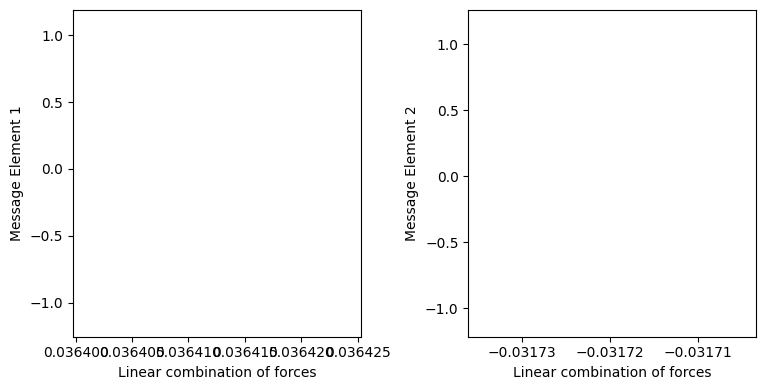

In [75]:
#Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = messages_over_time[i].copy()

    msgs['bd'] = msgs.r #+ 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        eps = 1.
        sigma = 1.
        force_fnc = lambda msg: 24*eps*((sigma)**12/(np.array(msg.bd)[:, None])**14 - (sigma)**6/(np.array(msg.bd)[:, None])**8) * np.array(msg[pos_cols])
        # force_fnc = lambda msg: -(np.array(msg.bd - 1))[:, None] * np.array(msg[pos_cols]) / np.array(msg.bd)[:, None]
        # if sim == 'spring':
        #     force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        
        # if sim == 'BD':
        #     force_fnc = lambda msg: (1/(msg.bd**12))[:, None] * np.array(msg[pos_cols]) 
            
        # if sim != 'spring' | sim != 'BD':
        #     raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")

        
        expected_forces = force_fnc(msgs)
        # print(expected_forces)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
    
from IPython.display import HTML
HTML(ani.to_jshtml())

In [72]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

In [73]:
ddf = messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

In [74]:
ddf

,e17,dx,dy,r,m1,m2
0,1.183240,-45.281334,-6.918370,45.806801,1.0,1.0
1,0.930736,-43.020355,-22.484306,48.541683,1.0,1.0
2,0.417592,-17.612396,3.457925,17.948643,1.0,1.0
3,0.842833,-38.996780,-21.769363,44.661549,1.0,1.0
4,0.743842,-3.630171,-6.457209,7.407678,1.0,1.0
...,...,...,...,...,...,...
3415,2.738991,-27.360304,-3.867836,27.632343,1.0,1.0
3416,3.890275,8.610125,31.243862,32.408535,1.0,1.0
3417,2.402642,-0.680152,7.370069,7.401386,1.0,1.0
3418,-1.126476,-19.345779,-5.177654,20.026665,1.0,1.0


In [ ]:
fig = plt.figure()
plt.plot(ddf.r, ddf.e41, 'k.')

plt.show()

# **Scaling**

In [ ]:
# Number of simulations to run (it's fast, don't worry):
ns = 100

# Potential (see below for options)
sim = 'spring'

# Number of nodes
# n = 2

# Dimension
dim = 2

# Number of time steps
nt = 100

# Time step

dt = 0.01

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
{'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
{'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
{'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
# dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

for i in range(0,9):

  n=i+2

  title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
  print('Running on', title)


  # ??? Why nt//2
  from simulate import SimulationDataset
  s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt) 

  # Update this to your own dataset, or regenerate:
  base_str = './'
  data_str = title
  s.simulate(ns)

  # data has [simulation ID, time, particle ID, [posx, posy, velx, vely, charge, mass]]
  data = s.data
  accel_data = s.get_acceleration()
  
  onp.save("data_n{0}.npy".format(n), data)
  onp.save("accel_data_n{0}.npy".format(n), accel_data)

  print(i)







In [ ]:
curloss=onp.zeros(9)
execTime=onp.zeros(9)

for ii in range(0,9):

  n=ii+2
  
  data = None
  accel_data = None

  data = onp.load("data_n{0}.npy".format(n))
  accel_data = onp.load("accel_data_n{0}.npy".format(n))

  X = torch.from_numpy(np.concatenate([data[:, i] for i in range(0, data.shape[1], 5)]))
  y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, data.shape[1], 5)]))

  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)


  # L1 regularization

  aggr = 'add'
  hidden = 300

  test = '_l1_'


  #This test applies an explicit bottleneck:

  msg_dim = 100
  n_f = data.shape[3]


  # Custom data loader

  edge_index = get_edge_index(n, sim)


  # Initiate the model

  if test == '_kl_':
      ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)
  else:
      ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).to(device)

  messages_over_time = []
  ogn = ogn.to(device)


  # Test the model
  _q = Data(
      x=X_train[0].to(device),
      edge_index=edge_index.to(device),
      y=y_train[0].to(device))
  ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 






  ## Set up training

  # Organize into data loader:

  batch = int(64 * (4 / n)**2)
  trainloader = DataLoader(
      [Data(
          Variable(X_train[i]),
          edge_index=edge_index,
          y=Variable(y_train[i])) for i in range(len(y_train))],
      batch_size=batch,
      shuffle=True
  )

  testloader = DataLoader(
      [Data(
          X_test[i],
          edge_index=edge_index,
          y=y_test[i]) for i in range(len(y_test))],
      batch_size=1024,
      shuffle=True
  )

  # We'll use OneCycleLR for fast training:








  # Set up optimizer and training parameters: Use 200 epochs for full version; can use fewer for test.
  init_lr = 1e-3

  opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

  # total_epochs = 200
  total_epochs = 5
  epoch = 0


  batch_per_epoch = int(1000*10 / (batch/32.0))

  sched = OneCycleLR(opt, max_lr=init_lr,
                    steps_per_epoch=batch_per_epoch,#len(trainloader),
                    epochs=total_epochs, final_div_factor=1e5)






  # Organize the recording of messages over time This is for fitting the forces, and extracting laws:

  test_idxes = onp.random.randint(0, len(X_test), 1000)

  #Record messages over test dataset here:
  newtestloader = DataLoader(
      [Data(
          X_test[i],
          edge_index=edge_index,
          y=y_test[i]) for i in test_idxes],
      batch_size=len(X_test),
      shuffle=False
  )



  ### Train the model:
  # Training loop
  recorded_activenet_models = []

  start_time = time.time()
  for epoch in tqdm(range(epoch, total_epochs)):
      ogn.to(device)
      total_loss = 0.0
      i = 0
      num_items = 0
      while i < batch_per_epoch:
          for ginput in trainloader:
              if i >= batch_per_epoch:
                  break
              opt.zero_grad()
              ginput.x = ginput.x.to(device)
              ginput.y = ginput.y.to(device)
              ginput.edge_index = ginput.edge_index.to(device)
              ginput.batch = ginput.batch.to(device)
              if test in ['_l1_', '_kl_']:
                  loss, reg = new_loss(ogn, ginput, square=False)
                  ((loss + reg)/int(ginput.batch[-1]+1)).backward()
              else:
                  loss = ogn.loss(ginput, square=False)
                  (loss/int(ginput.batch[-1]+1)).backward()
              opt.step()
              sched.step()

              total_loss += loss.item()
              i += 1
              num_items += int(ginput.batch[-1]+1)

      cur_loss = total_loss/num_items
      print(cur_loss)
      cur_msgs = get_messages(ogn)
      cur_msgs['epoch'] = epoch
      cur_msgs['loss'] = cur_loss
      messages_over_time.append(cur_msgs)
      
      ogn.cpu()

      recorded_activenet_models.append(ogn.state_dict())
      
  execTime[ii] = time.time() - start_time
  curloss[ii] = cur_loss





In [ ]:
nParts=[2,3,4,5,6,7,8,9,10]

In [ ]:
onp.save("trainingTimeVSnParticles.npy", execTime)
onp.save("lossVSnParticles.ny", curloss)


In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

fig.suptitle('Nepochs = 5, Nsteps = 100, Nsims = 100', fontsize=16)

ax1.plot(nParts, execTime, 'o', label='data')
ax1.plot(nParts, 10*onp.square(nParts), '-', label='$n^2$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(90,1100)
ax1.legend()
# ax1.grid(True)
ax1.set_xlabel('Number of particles', fontsize=12)
ax1.set_ylabel('Training time', fontsize=12)
#ax1.axes.get_xaxis().set_visible(False)

ax2.plot(nParts, curloss, 'o', label='data')
ax2.plot(nParts, 0.001*onp.power(nParts,3), '-', label='$l^3$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0.08,1.1)
ax2.legend()
ax2.set_xlabel('Number of particles', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)

In [ ]:
fig.savefig('trainingTime-LossVSnParticles.png')